# 1. Dataset Overview

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”

# 2. Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("potential-talents - Aspiring human resources - seeking human resources.csv", index_col='id')
df.head()

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


# 3. Data Preprocessing

There were 104 rows in the dataframe
Now, there are 53 rows in the dataframe after removing duplicate values


Text(0.5, 0, 'Number of Candidates')

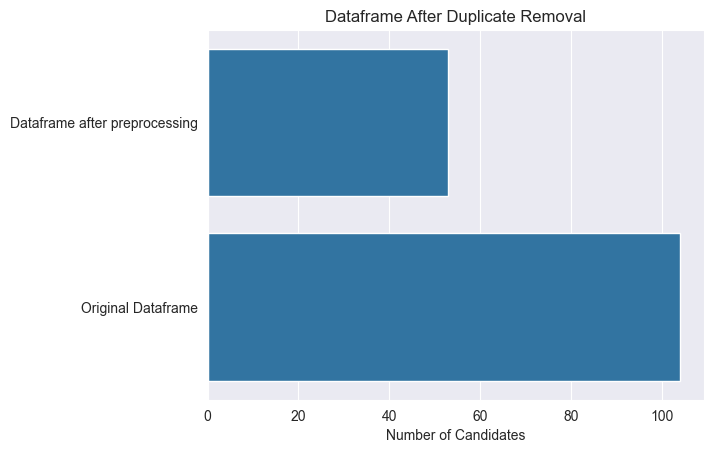

In [4]:
# Remove Duplicates
print(f'There were {len(df)} rows in the dataframe')
dff = df.drop_duplicates()
print(f'Now, there are {len(dff)} rows in the dataframe after removing duplicate values')

plt.figure()
sns.barplot(y=['Dataframe after preprocessing', 'Original Dataframe'], x=[len(dff), len(df)])
plt.title("Dataframe After Duplicate Removal")
plt.xlabel("Number of Candidates")

In [5]:
dff.describe(include='all')

,job_title,location,connection,fit
count,53,53,53,0.0
unique,52,41,33,NaN
top,Aspiring Human Resources Professional,"Houston, Texas Area",500+,NaN
freq,2,4,18,NaN
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN


In [6]:
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import get_tmpfile

# Stopword Removal
df_cleaned = dff.copy()

stopWords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and lemmatize job titles
def clean_job_title(jobTitle):
    # Replace specific abbreviations and convert to lowercase
    jobTitle = jobTitle.replace("HR", " human resources ").lower()
    jobTitle = jobTitle.replace("HRIS", " human resources information system ").lower()
    jobTitle = jobTitle.replace("SPHR", " senior professional in human resources ").lower()
    jobTitle = jobTitle.replace("GPHR", " global professional in human resources ").lower()
    jobTitle = jobTitle.replace("CHRO", " chief human resources officer ").lower()

    # Lemmatize and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in jobTitle.split() if word.isalnum() and word not in stopWords]

    return " ".join(words)

# Apply the function to each job title
df_cleaned['jobTitleCleaned'] = df_cleaned['job_title'].apply(clean_job_title)

In [7]:
df_cleaned.head()

,job_title,location,connection,fit,jobTitleCleaned
id,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 bauer college business graduate cum aspir...
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik program
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resource professional
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university


# 4. Ranking Candidates

## TF-IDF

In [8]:
keyPhrases = ['aspiring human resources', 'seeking human resources']

keyPhrases = [' '.join([lemmatizer.lemmatize(token) for token in phrase.split()]) for phrase in keyPhrases]

jobTitleList = list(df_cleaned['jobTitleCleaned'])

In [9]:
def cosine_sim(v1, v2):
    return 1 - cosine(v1, v2)

In [10]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Tf-Idf of job titles
tfidfVectors = vectorizer.fit_transform(df_cleaned['jobTitleCleaned']).toarray()

# Tf-Idf of key phrases
keyVectors = vectorizer.transform(keyPhrases).toarray()

In [11]:
score1Array = np.apply_along_axis(cosine_sim, 1, tfidfVectors, keyVectors[0])
score2Array = np.apply_along_axis(cosine_sim, 1, tfidfVectors, keyVectors[1])

# Compute average cosine similarity score
cosSimScore = (score1Array + score2Array) / 2

# Assign the results back to the DataFrame
df_cleaned['score1'] = score1Array
df_cleaned['score2'] = score2Array
df_cleaned['cosSimScore'] = cosSimScore

In [12]:
df_cleaned[['jobTitleCleaned', 'cosSimScore']].sort_values(by=['cosSimScore'], ascending=False).head()

,jobTitleCleaned,cosSimScore
id,,
73,aspiring human resource seeking internship human,0.626063
10,seeking human resource human resource generali...,0.544917
97,aspiring human resource professional,0.536425
3,aspiring human resource professional,0.536425
99,seeking human resource position,0.495025


## Word Embedding

### 1. GloVe

In [13]:
from gensim.test.utils import get_tmpfile

target_file = get_tmpfile('word2vec.6B.50d.txt')
glove2word2vec('glove.6B.50d.txt', target_file)

glove_model = KeyedVectors.load_word2vec_format(target_file)

glove_model.save_word2vec_format('word2vec.6B.50d.bin.gz', binary = True)

C:\Users\asus\AppData\Local\Temp\ipykernel_8788\4196707061.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec('glove.6B.50d.txt', target_file)


In [14]:
def avg_doc_token_vectors(documents, model, vector_dimensions):
    document_vectors = []
    for sentence in documents:
        word_tokens = word_tokenize(sentence)
        filtered_words = [w for w in word_tokens if w in model.key_to_index.keys()]
        vectors = [model[word] if word in filtered_words else np.zeros(vector_dimensions) for word in word_tokens]
        document_vectors.append(np.mean(vectors, axis=0))
    return document_vectors

glove_vectors = avg_doc_token_vectors(df_cleaned['jobTitleCleaned'], glove_model, 50)

keyPhrases = ['aspiring human resources', 'seeking human resources']
glove_key_vectors = avg_doc_token_vectors(keyPhrases, glove_model, 50)

glove_similarity_scores = [cosine_sim(glove_vectors[i], glove_key_vectors[0]) for i in range(len(glove_vectors))]

df_cleaned['GloVe_sim_score'] = glove_similarity_scores

In [15]:
df_cleaned[['jobTitleCleaned', 'GloVe_sim_score']].sort_values(by=['GloVe_sim_score'], ascending=False).head()

,jobTitleCleaned,GloVe_sim_score
id,,
73,aspiring human resource seeking internship human,0.941376
6,aspiring human resource specialist,0.939268
3,aspiring human resource professional,0.931925
97,aspiring human resource professional,0.931925
76,aspiring human resource professional passionat...,0.916243


### 2. BERT

In [16]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [17]:
def get_bert_embedding(sentence):
    # Tokenize and encode sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    # Use the mean of the token embeddings as the sentence embedding
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1).squeeze().detach().numpy()
    return sentence_embedding

In [18]:
df_cleaned['bert_embedding'] = df_cleaned['jobTitleCleaned'].apply(get_bert_embedding)

In [19]:
key_bert_embeddings = [get_bert_embedding(phrase) for phrase in keyPhrases]

def bert_cosine_sim(v1, v2):
    return 1 - cosine(v1, v2)

for i, key_emb in enumerate(key_bert_embeddings):
    df_cleaned[f'bert_score_{i}'] = df_cleaned['bert_embedding'].apply(lambda x: bert_cosine_sim(x, key_emb))

df_cleaned['bert_avg_score'] = df_cleaned[[f'bert_score_{i}' for i in range(len(key_bert_embeddings))]].mean(axis=1)

In [20]:
df_cleaned[['jobTitleCleaned', 'bert_avg_score']].sort_values(by=['bert_avg_score'], ascending=False).head()

,jobTitleCleaned,bert_avg_score
id,,
99,seeking human resource position,0.876121
3,aspiring human resource professional,0.846641
97,aspiring human resource professional,0.846641
6,aspiring human resource specialist,0.840032
28,seeking human resource opportunity,0.834276
